In [2]:
import sys
# append the path of the parent directory
sys.path.append("..")

# External library imports
import datetime
import torch
import torch.nn as nn
import numpy as np
import random
from torch.optim import Adam
from torch.utils.data import DataLoader, Subset, random_split
import json
import os
import matplotlib.pyplot as plt

# internal library imports
from dataset import DebrisStatePairsDataset
from model import CNN, UNet
from train import TrainerPairs, CustomDebrisLoss
from util.setting_utils import set_seed






In [3]:
# Set the random seed for multiple libraries to ensure repeatability

set_seed(42)

In [4]:
def read_losses(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    # Extract the subfolder name as the series name
    series_name = os.path.basename(os.path.dirname(file_path))
    return series_name, data['training_losses'], data['validation_losses']

def plot_multiple_losses(files):
    plt.figure(figsize=(12, 6))
    
    for file_path in files:
        series_name, training_losses, validation_losses = read_losses(file_path)
        epochs = range(1, len(training_losses) + 1)
        
        plt.plot(epochs, training_losses, 'o-', label=f'{series_name} Training', linewidth=2)
        plt.plot(epochs, validation_losses, 'o--', label=f'{series_name} Validation', linewidth=2)

    plt.title('Training and Validation Losses for Multiple Models')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

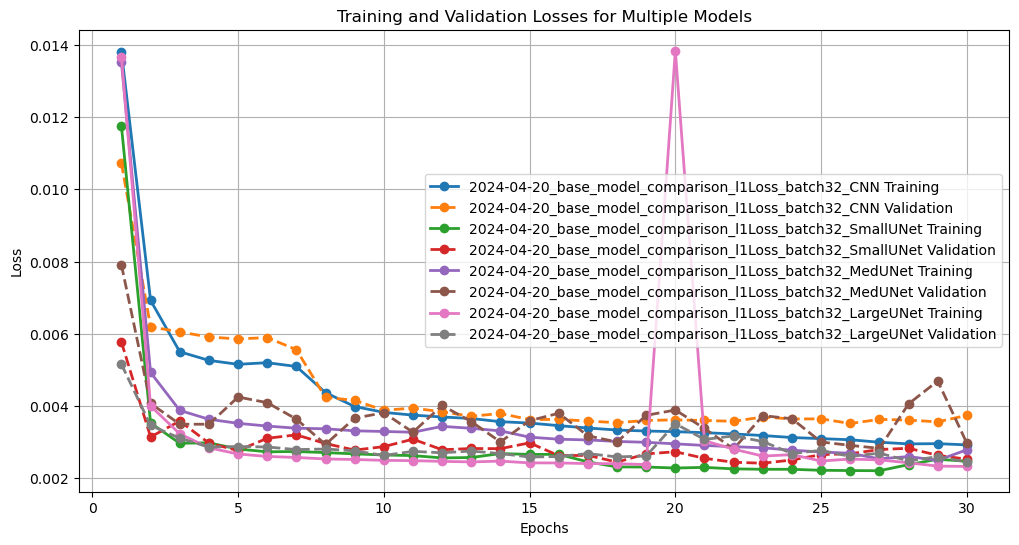

In [6]:
files = [
    '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-20_base_model_comparison_l1Loss_batch32_CNN/losses_epoch_30.json',
    '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-20_base_model_comparison_l1Loss_batch32_SmallUNet/losses_epoch_30.json',
    '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-20_base_model_comparison_l1Loss_batch32_MedUNet/losses_epoch_30.json',
    '/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-20_base_model_comparison_l1Loss_batch32_LargeUNet/losses_epoch_30.json'
]

plot_multiple_losses(files)

In [3]:
# Parameters

root_dir = r'/home/tom/repos/dyna-landslide-surrogate/data_experiment'
checkpoint_dir = r'/home/tom/repos/dyna-landslide-surrogate/checkpoints'
batch_size = 32
split_proportions = (0.7, 0.15, 0.15)
epochs = 30

in_channels = 3  # Number of input channels (e.g., terrain, velocity, thickness)
out_channels = 2  # Number of output channels (e.g., next velocity, next thickness)

In [4]:
# Data set up

# Initialize dataset with scaling
dataset = DebrisStatePairsDataset(root_dir, array_size=256, apply_scaling=True)

# Split dataset into train, validation, and test sets and create dataloaders
train_loader, val_loader, test_loader = dataset.create_dataloaders(split_proportions, batch_size, random_state=42)



# Dataset stats
print(f"Total dataset size: {len(dataset)}")
print(f"Train size: {len(train_loader.dataset)}, Validation size: {len(val_loader.dataset)}, Test size: {len(test_loader.dataset)}")

Total dataset size: 12042
Train size: 8914, Validation size: 1398, Test size: 1730


In [5]:
# # Create an instance of each architecture
# cnn = CNN()
# small_unet = UNet(in_channels=3, out_channels=2, features=[64, 128, 256])
# med_unet = UNet(in_channels=3, out_channels=2, features=[64, 128, 256, 512])
# large_unet = UNet(in_channels=3, out_channels=2, features=[64, 128, 256, 512, 1024])

# # Calculate the number of parameters for each architecture
# cnn_params = sum(p.numel() for p in cnn.parameters())
# small_unet_params = sum(p.numel() for p in small_unet.parameters())
# med_unet_params = sum(p.numel() for p in med_unet.parameters())
# large_unet_params = sum(p.numel() for p in large_unet.parameters())

# # Print the number of parameters for each architecture
# print("ComplexCNN parameters:", cnn_params)
# print("SimpleUNet parameters:", small_unet_params)
# print("LargeUNet parameters:", med_unet_params)
# print("UNet parameters:", large_unet_params)

In [6]:
# Set up CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn = CNN().to(device)

# Check if multiple GPUs are available and wrap the model using nn.DataParallel
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    # This will wrap the model for use with multiple GPUs
    cnn = nn.DataParallel(cnn)

# Define the loss function and optimizer
# criterion = nn.MSELoss()
criterion = nn.L1Loss()
# criterion = CustomDebrisLoss(loss_fn_zero=nn.SmoothL1Loss(), loss_fn_debris=nn.SmoothL1Loss(), debris_weight=0.66)
optimizer = Adam(cnn.parameters(), lr=1e-3)

cnn_trainer = TrainerPairs(cnn, optimizer, criterion, device, model_name="cnn", checkpoint_dir=checkpoint_dir)

cnn_trainer.load_checkpoint("/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-20_base_model_comparison_l1Loss_batch32_CNN/model_epoch_30.pth")

Using 2 GPUs!
Model loaded from /home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-20_base_model_comparison_l1Loss_batch32_CNN/model_epoch_30.pth


In [7]:
cnn_trainer.test(test_loader)

Test Custom Loss: 0.7576
Test L1 Loss: 0.0042
Test MSE: 0.0109
Test RMSE: 0.1042
Test PSNR: 50.8356


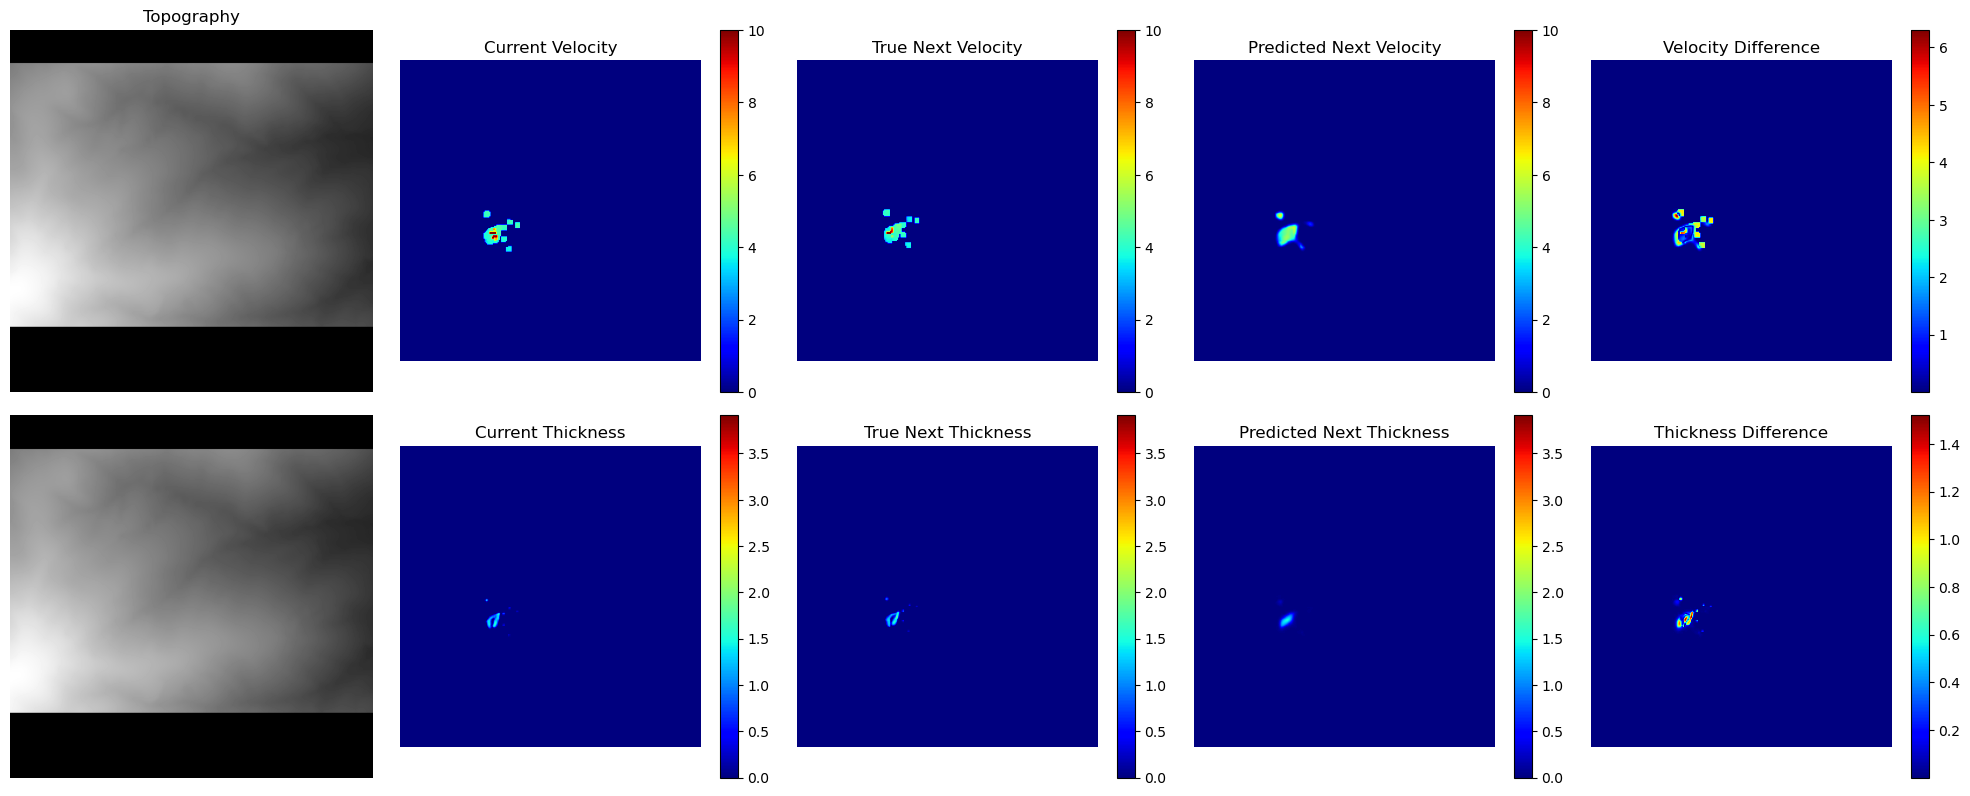

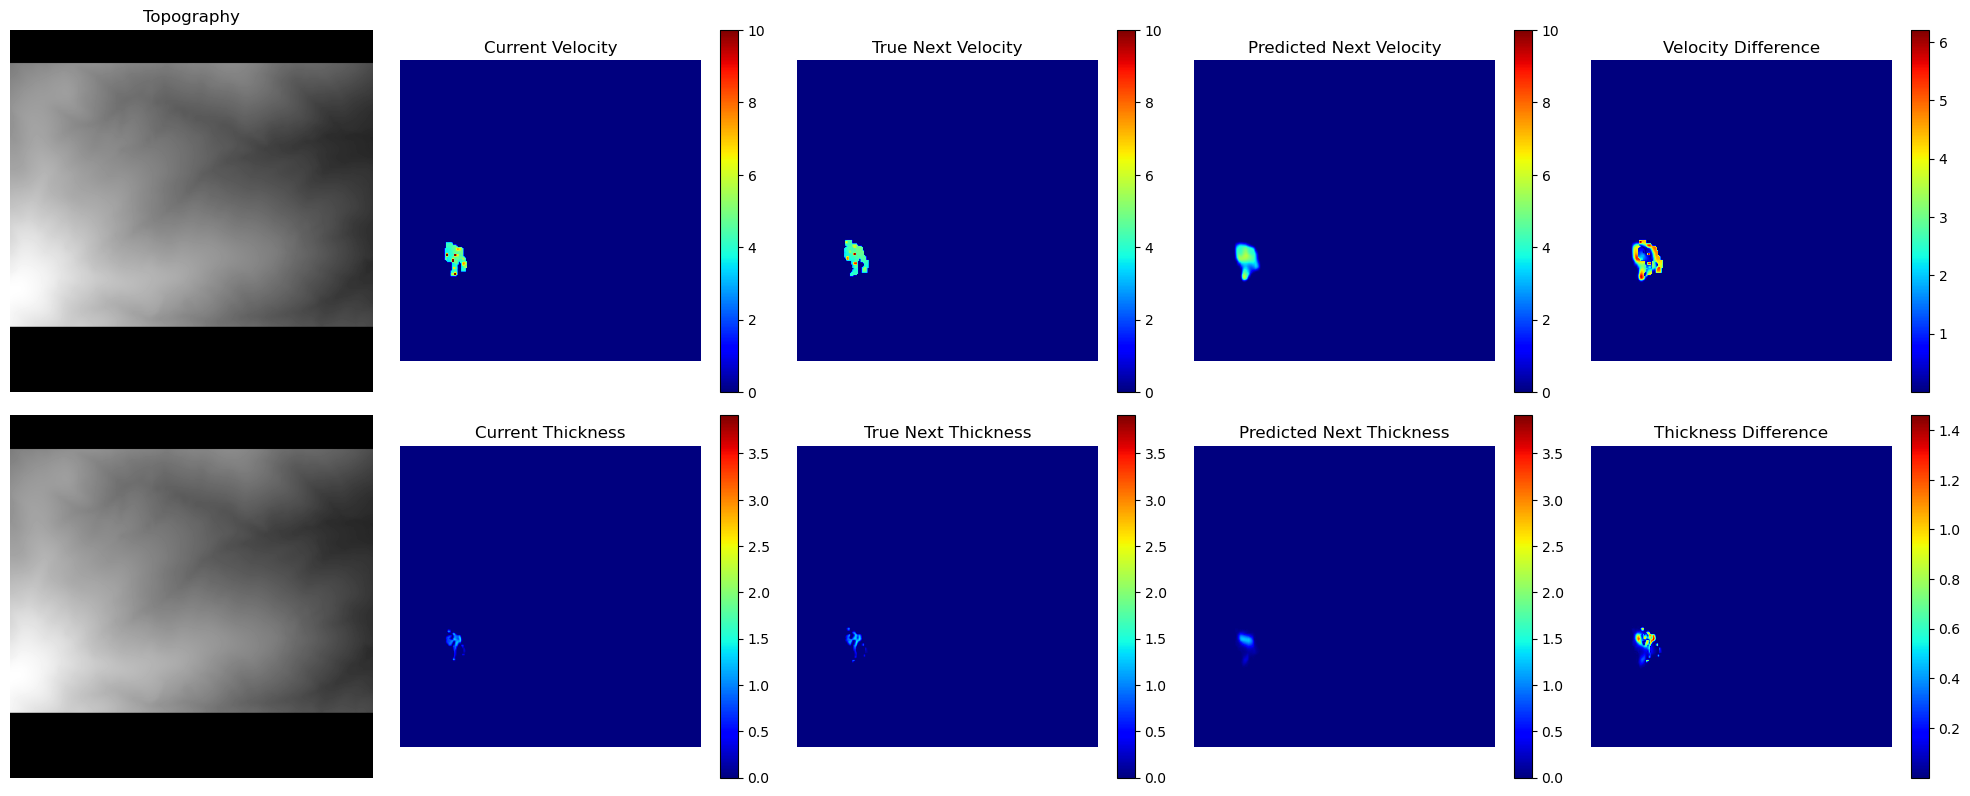

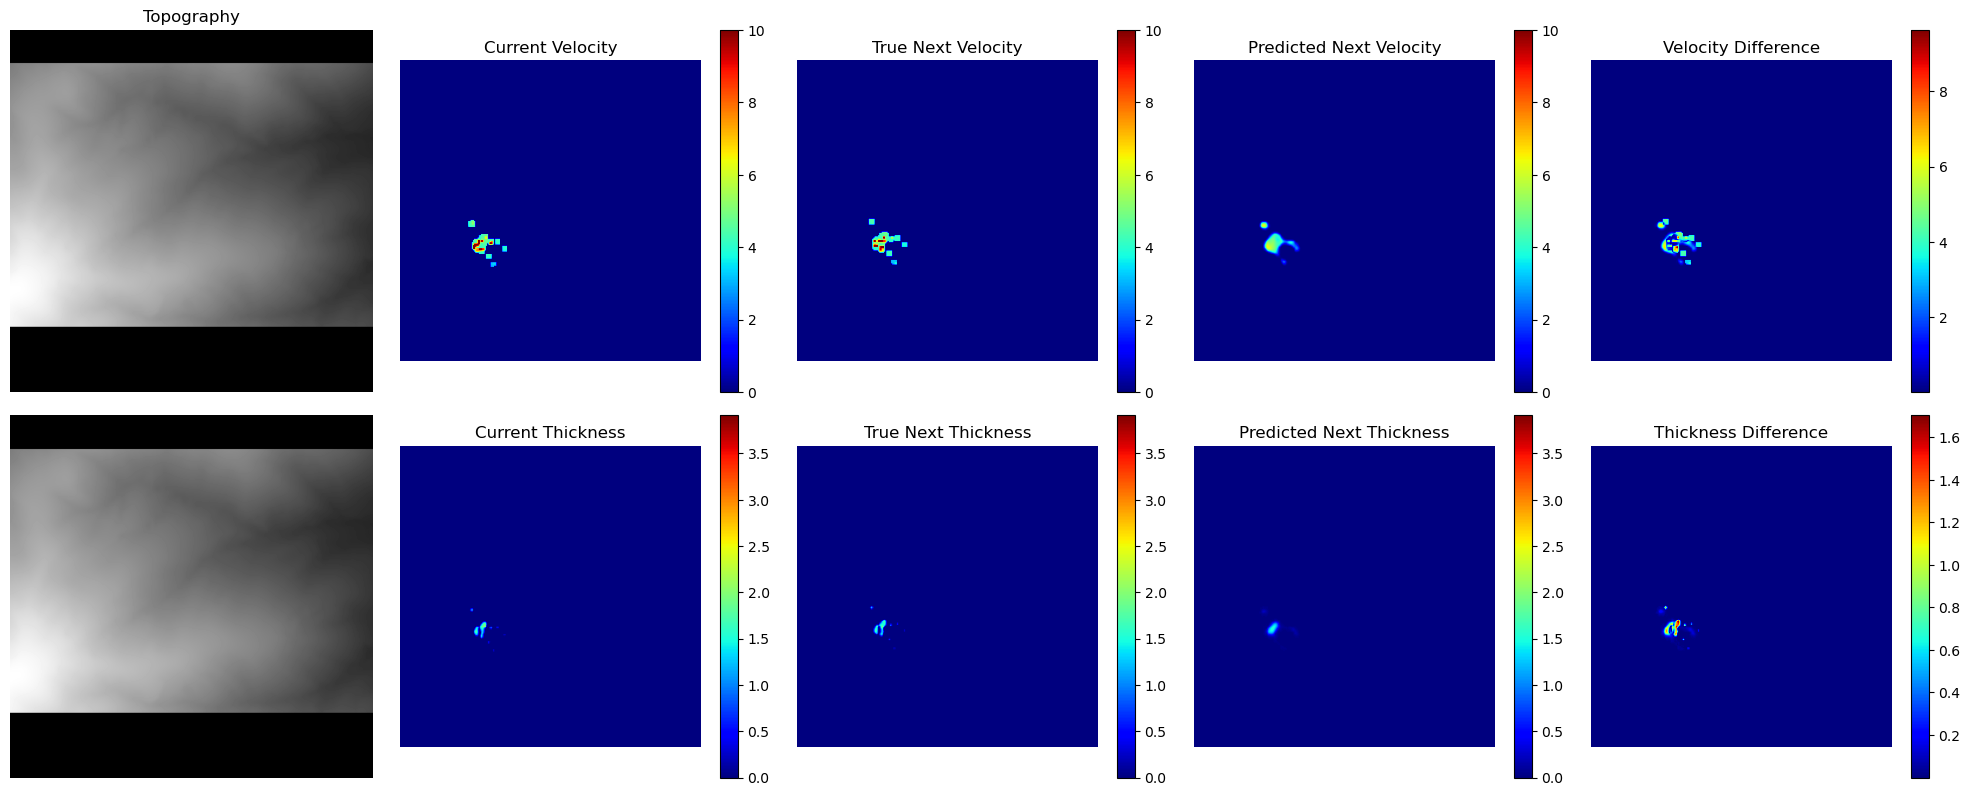

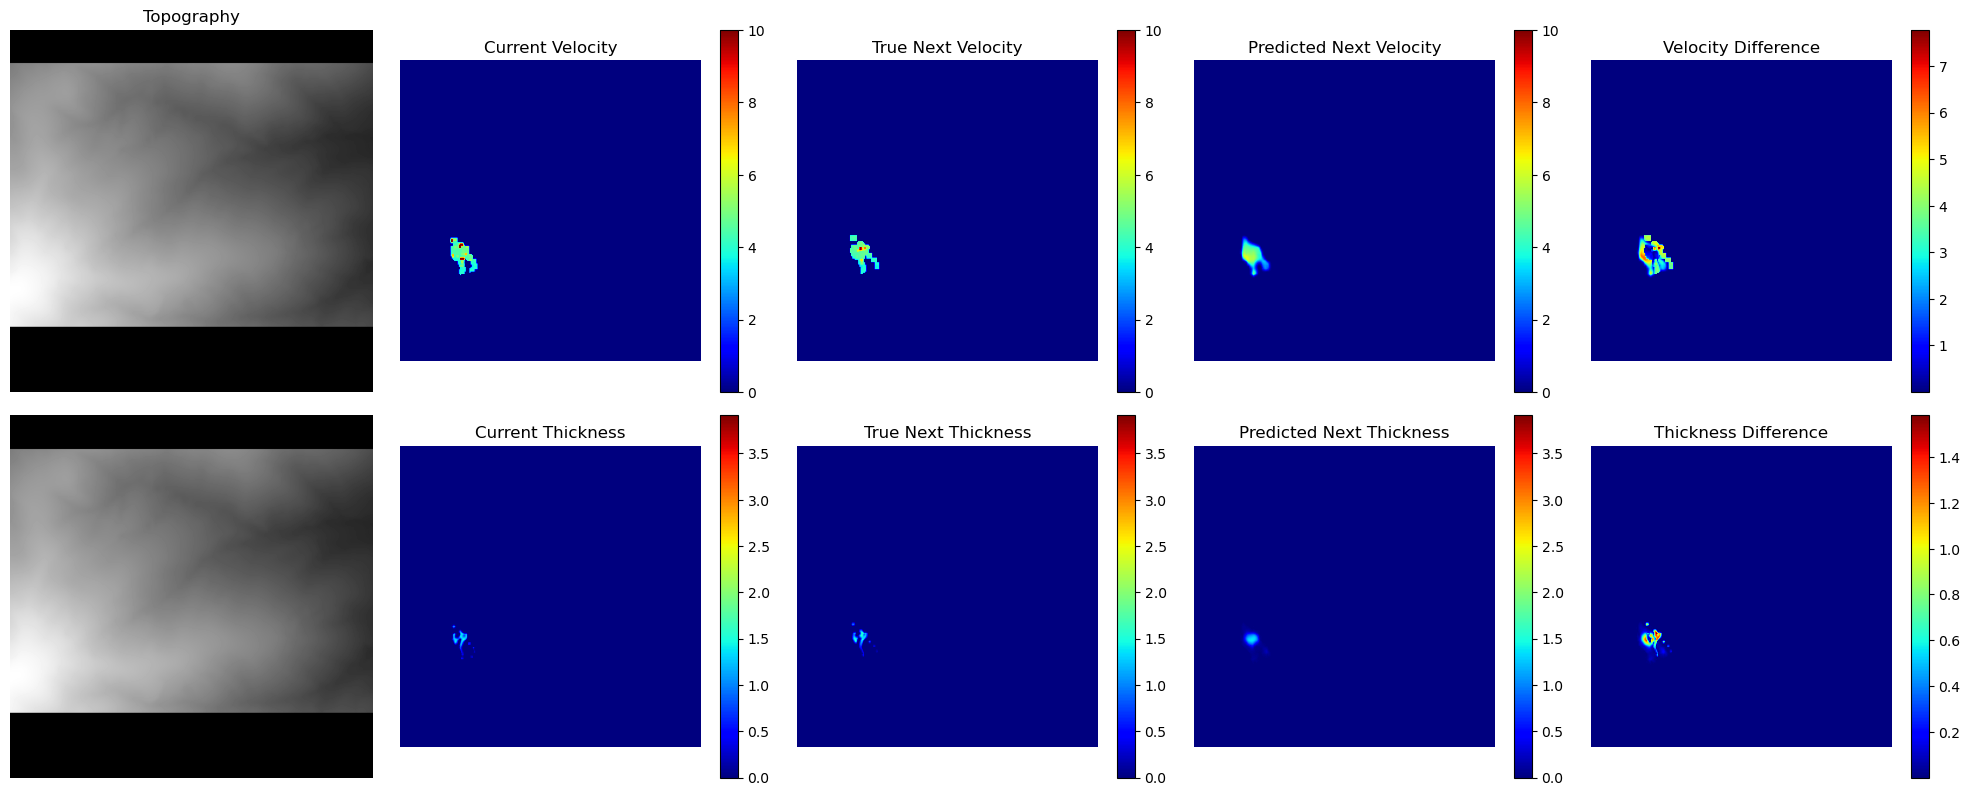

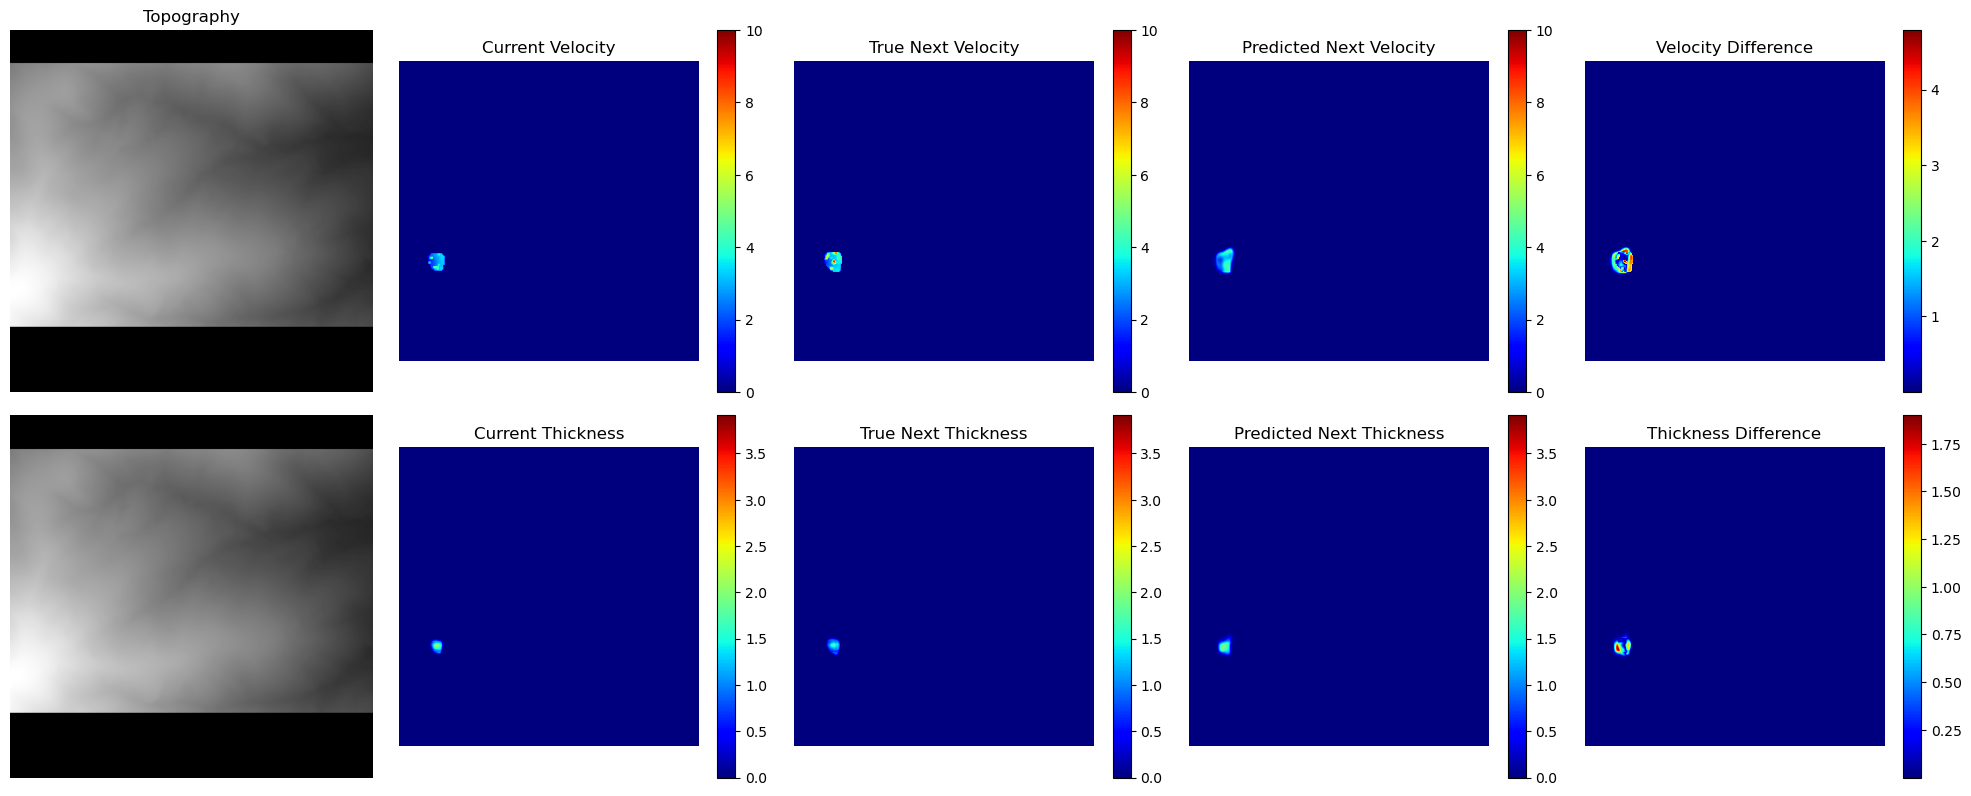

In [8]:
cnn_trainer.plot_predictions(test_loader, num_predictions=5)

In [9]:
# Set up CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

small_unet = UNet(in_channels=3, out_channels=2, features=[64, 128, 256]).to(device)

# Check if multiple GPUs are available and wrap the model using nn.DataParallel
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    # This will wrap the model for use with multiple GPUs
    small_unet = nn.DataParallel(small_unet)

# Define the loss function and optimizer
# criterion = nn.MSELoss()
criterion = nn.L1Loss()
# criterion = CustomDebrisLoss(loss_fn_zero=nn.SmoothL1Loss(), loss_fn_debris=nn.SmoothL1Loss(), debris_weight=0.66)
optimizer = Adam(cnn.parameters(), lr=1e-3)

small_unet_trainer = TrainerPairs(small_unet, optimizer, criterion, device, model_name="small_unet", checkpoint_dir=checkpoint_dir)

small_unet_trainer.load_checkpoint("/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-20_base_model_comparison_l1Loss_batch32_SmallUNet/model_epoch_30.pth")

Using 2 GPUs!
Model loaded from /home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-20_base_model_comparison_l1Loss_batch32_SmallUNet/model_epoch_30.pth


In [10]:
small_unet_trainer.test(test_loader)

Test Custom Loss: 0.4700
Test L1 Loss: 0.0026
Test MSE: 0.0072
Test RMSE: 0.0847
Test PSNR: 53.6879


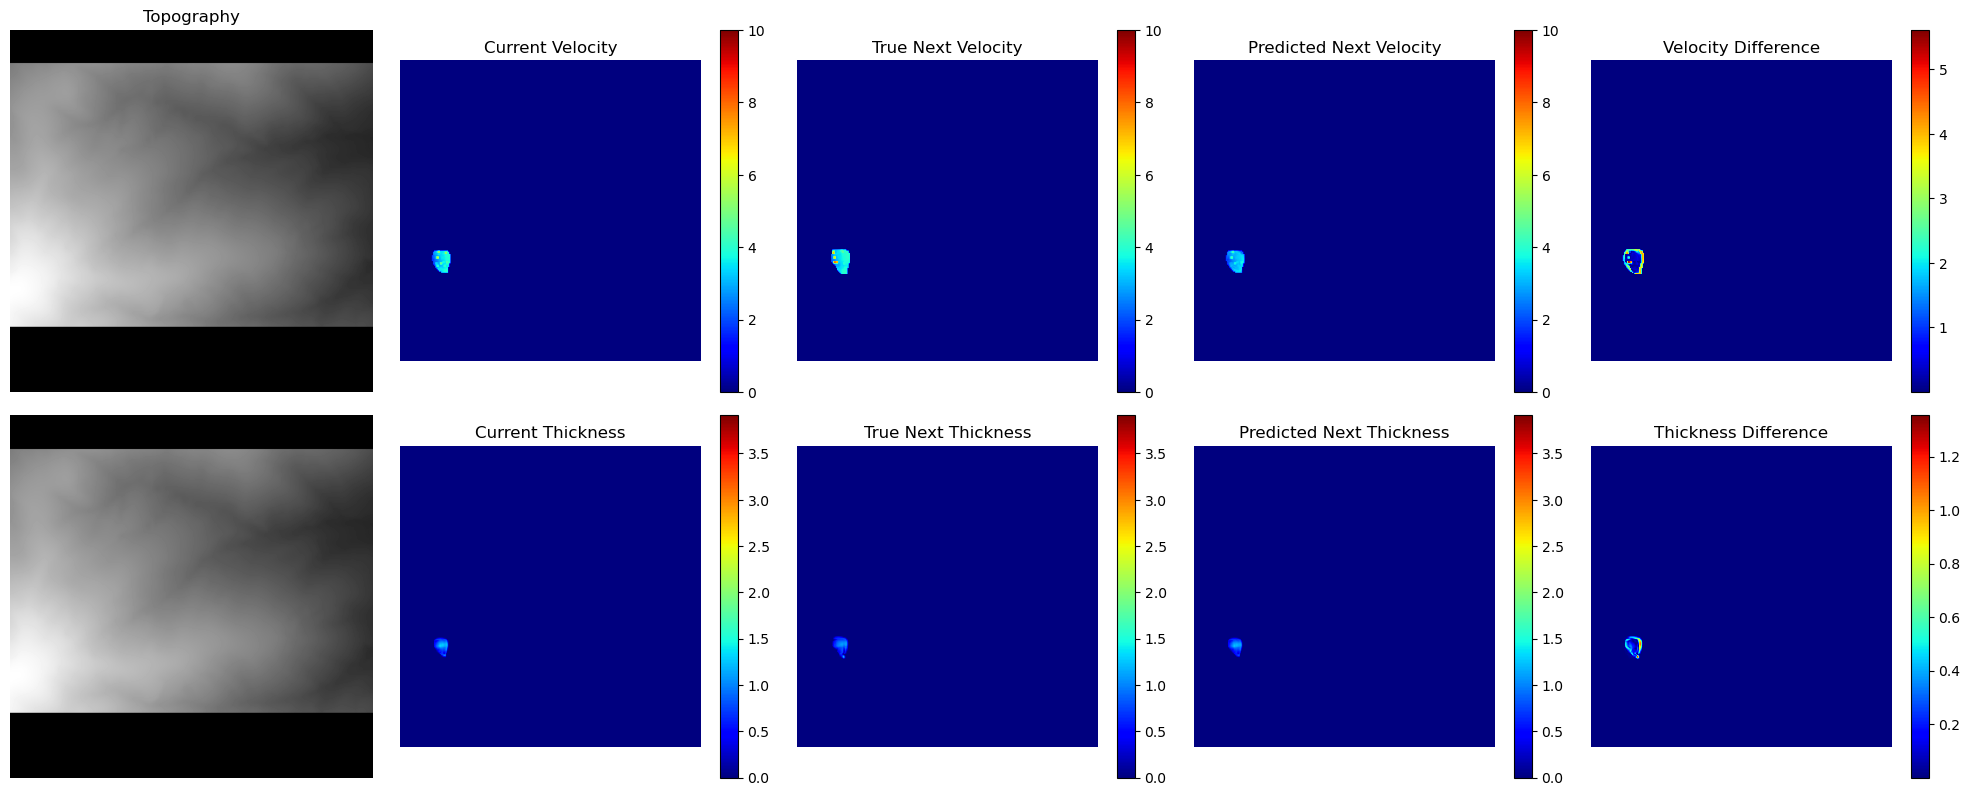

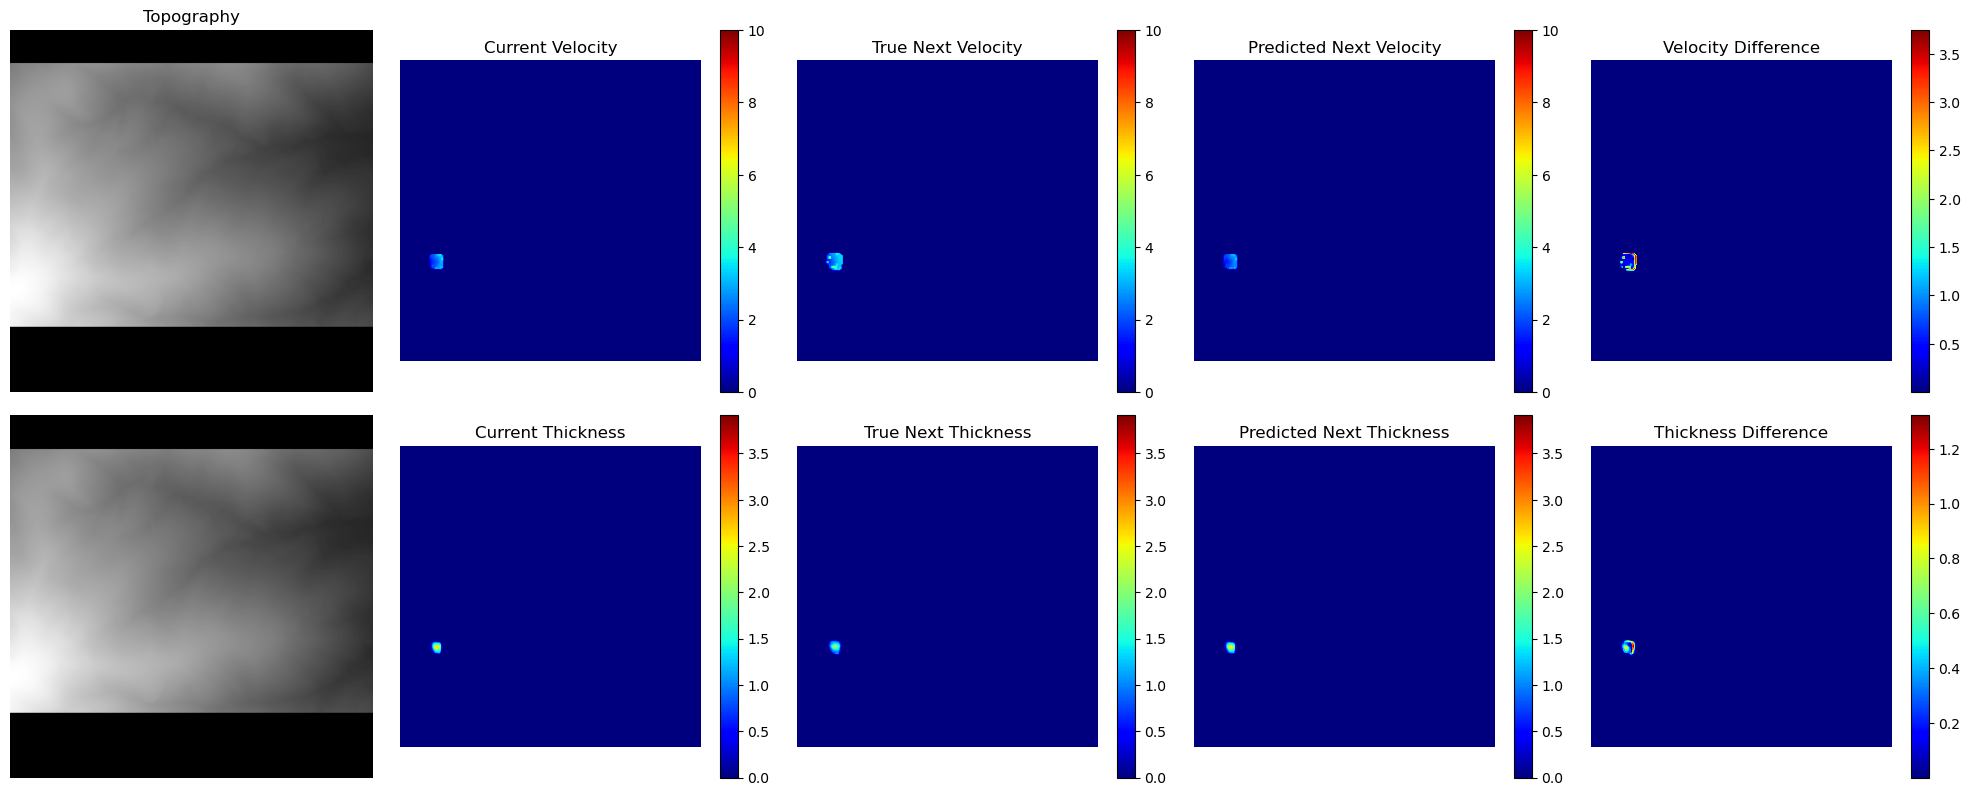

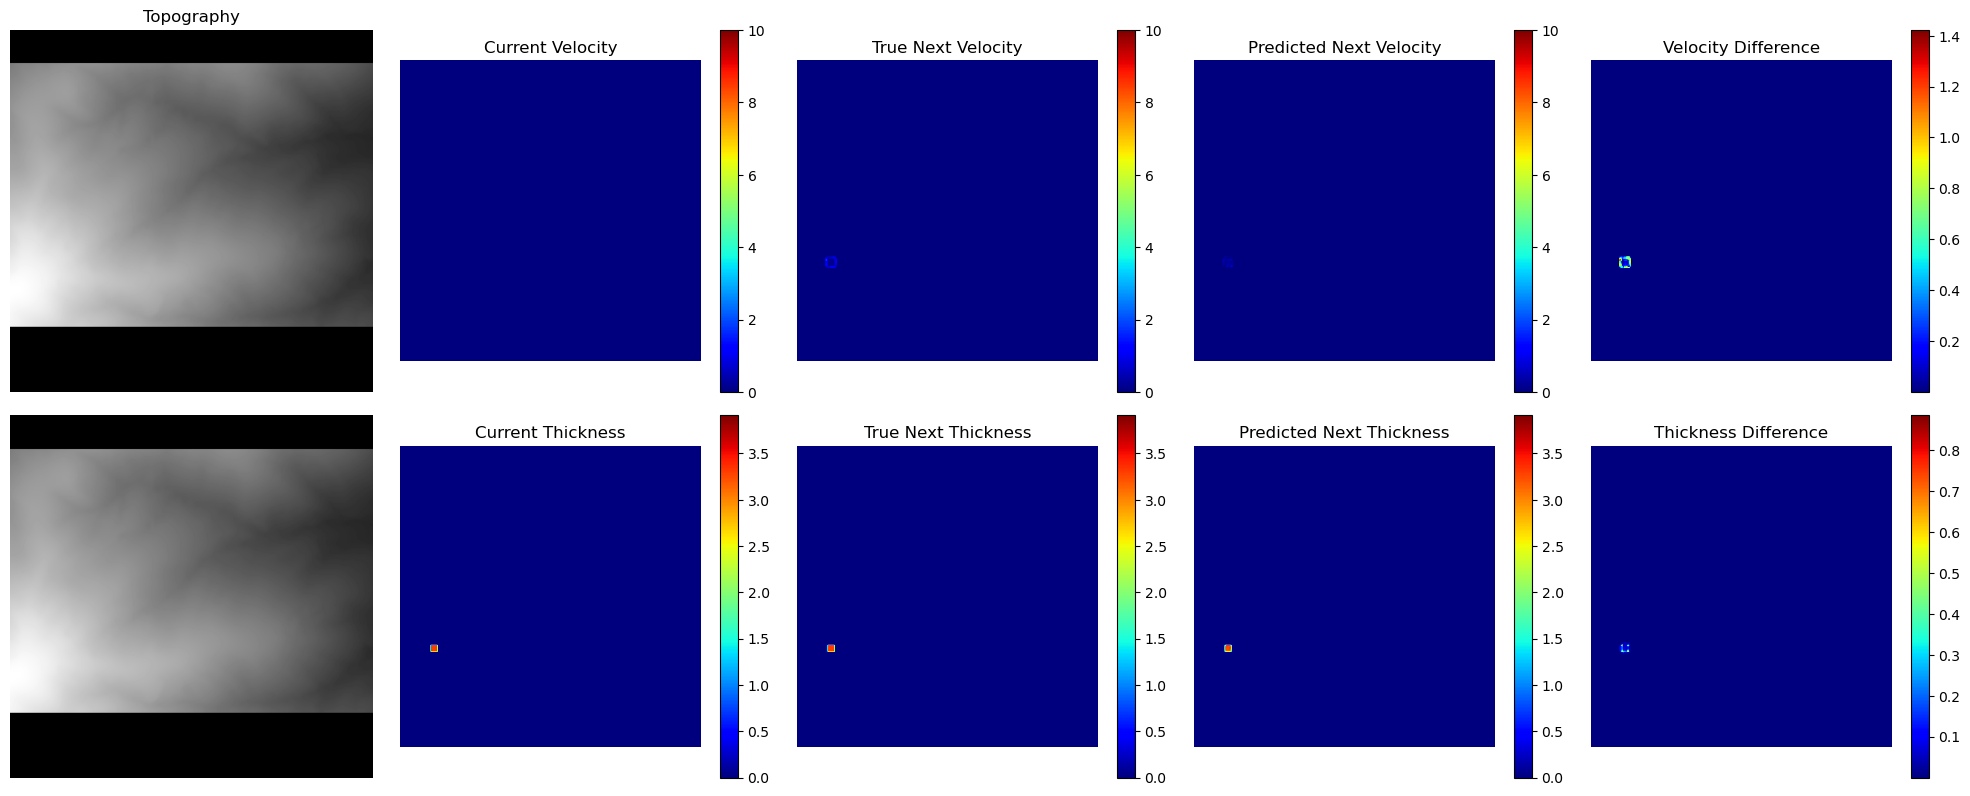

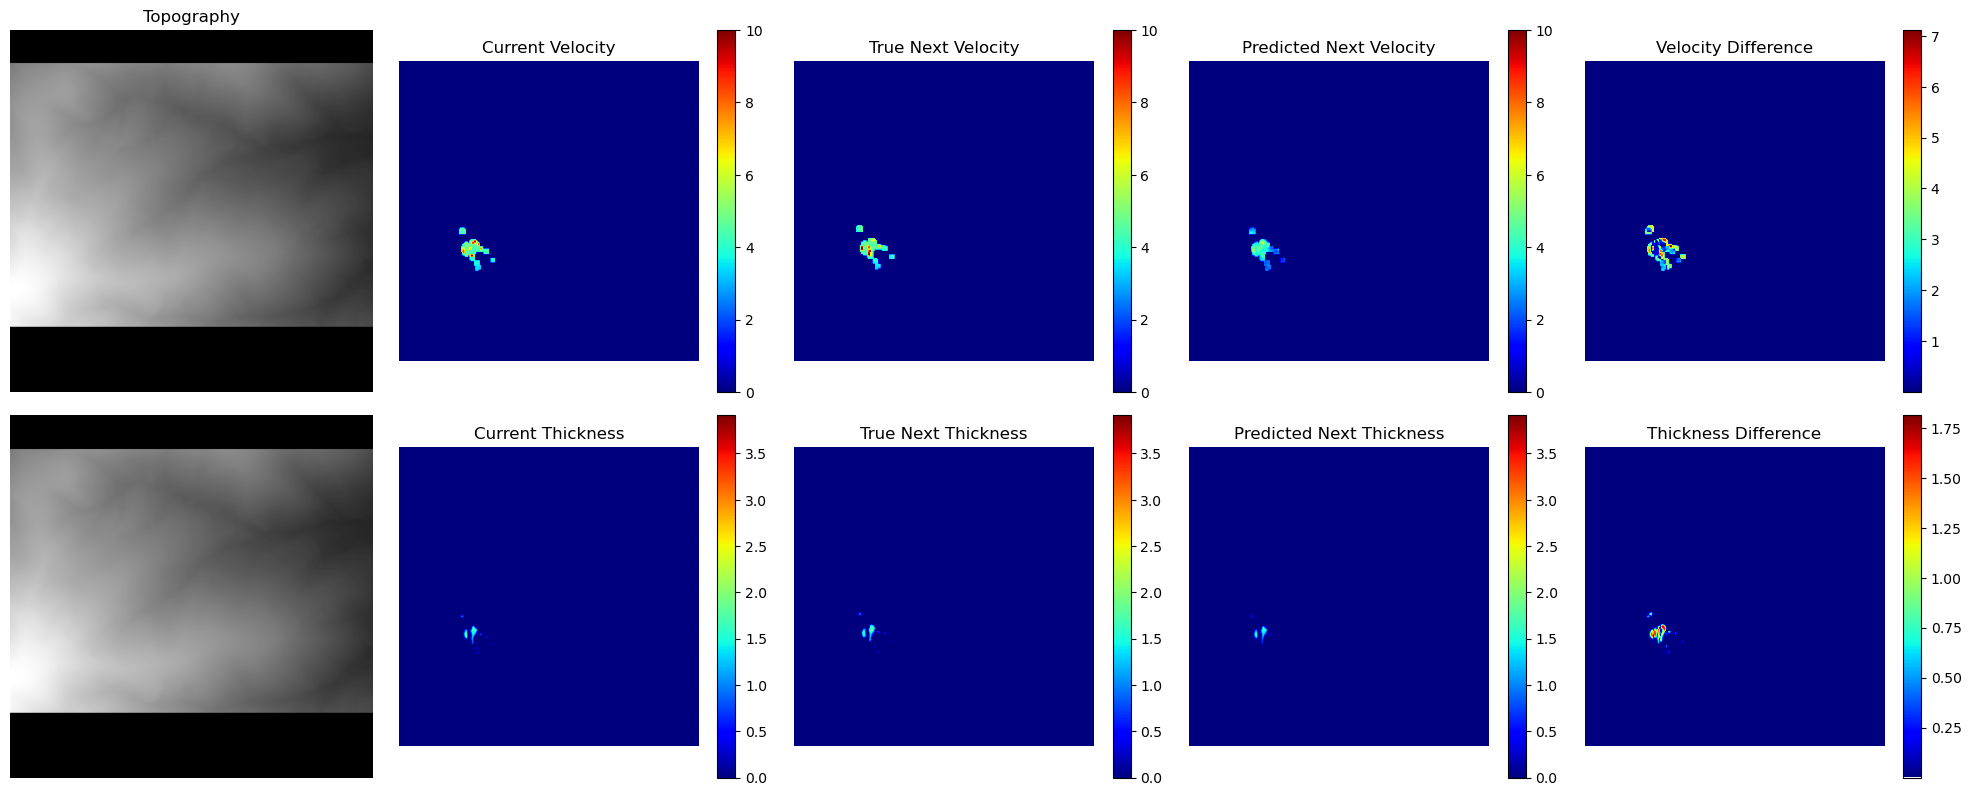

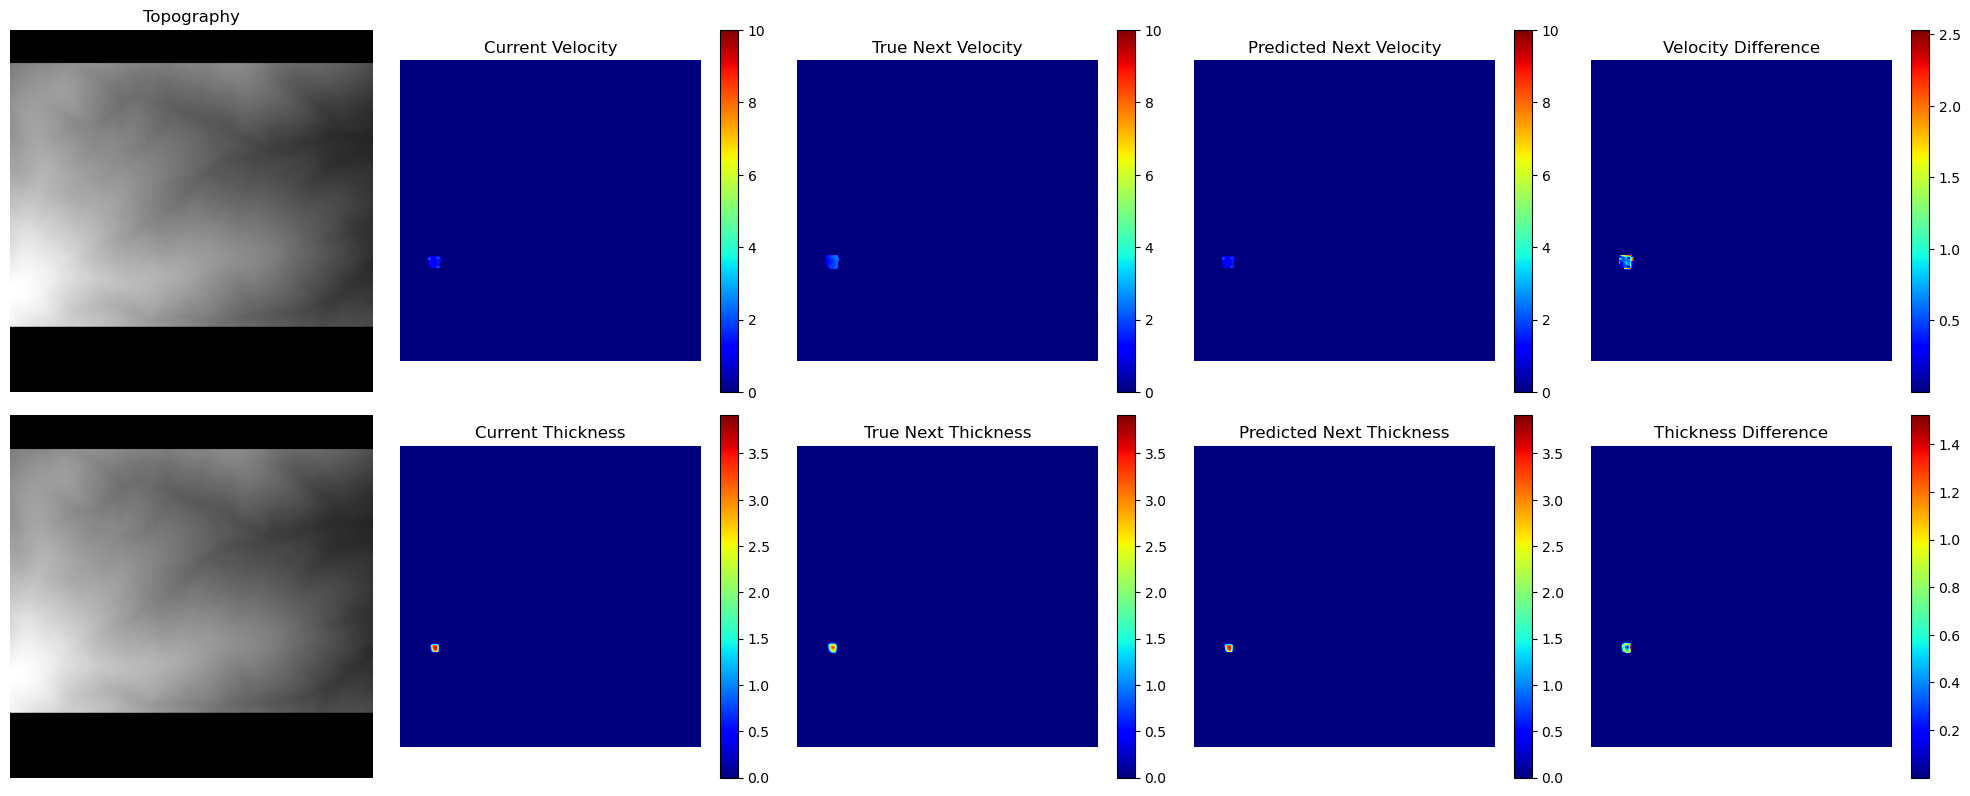

In [11]:
small_unet_trainer.plot_predictions(test_loader, num_predictions=5)

In [12]:
# Set up CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

med_unet = UNet(in_channels=3, out_channels=2, features=[64, 128, 256, 512]).to(device)

# Check if multiple GPUs are available and wrap the model using nn.DataParallel
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    # This will wrap the model for use with multiple GPUs
    med_unet = nn.DataParallel(med_unet)

# Define the loss function and optimizer
# criterion = nn.MSELoss()
criterion = nn.L1Loss()
# criterion = CustomDebrisLoss(loss_fn_zero=nn.SmoothL1Loss(), loss_fn_debris=nn.SmoothL1Loss(), debris_weight=0.66)
optimizer = Adam(cnn.parameters(), lr=1e-3)

med_unet_trainer = TrainerPairs(med_unet, optimizer, criterion, device, model_name="med_unet", checkpoint_dir=checkpoint_dir)

med_unet_trainer.load_checkpoint("/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-20_base_model_comparison_l1Loss_batch32_MedUNet/model_epoch_30.pth")

Using 2 GPUs!
Model loaded from /home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-20_base_model_comparison_l1Loss_batch32_MedUNet/model_epoch_30.pth


In [13]:
med_unet_trainer.test(test_loader)

Test Custom Loss: 0.4685
Test L1 Loss: 0.0031
Test MSE: 0.0073
Test RMSE: 0.0856
Test PSNR: 53.3101


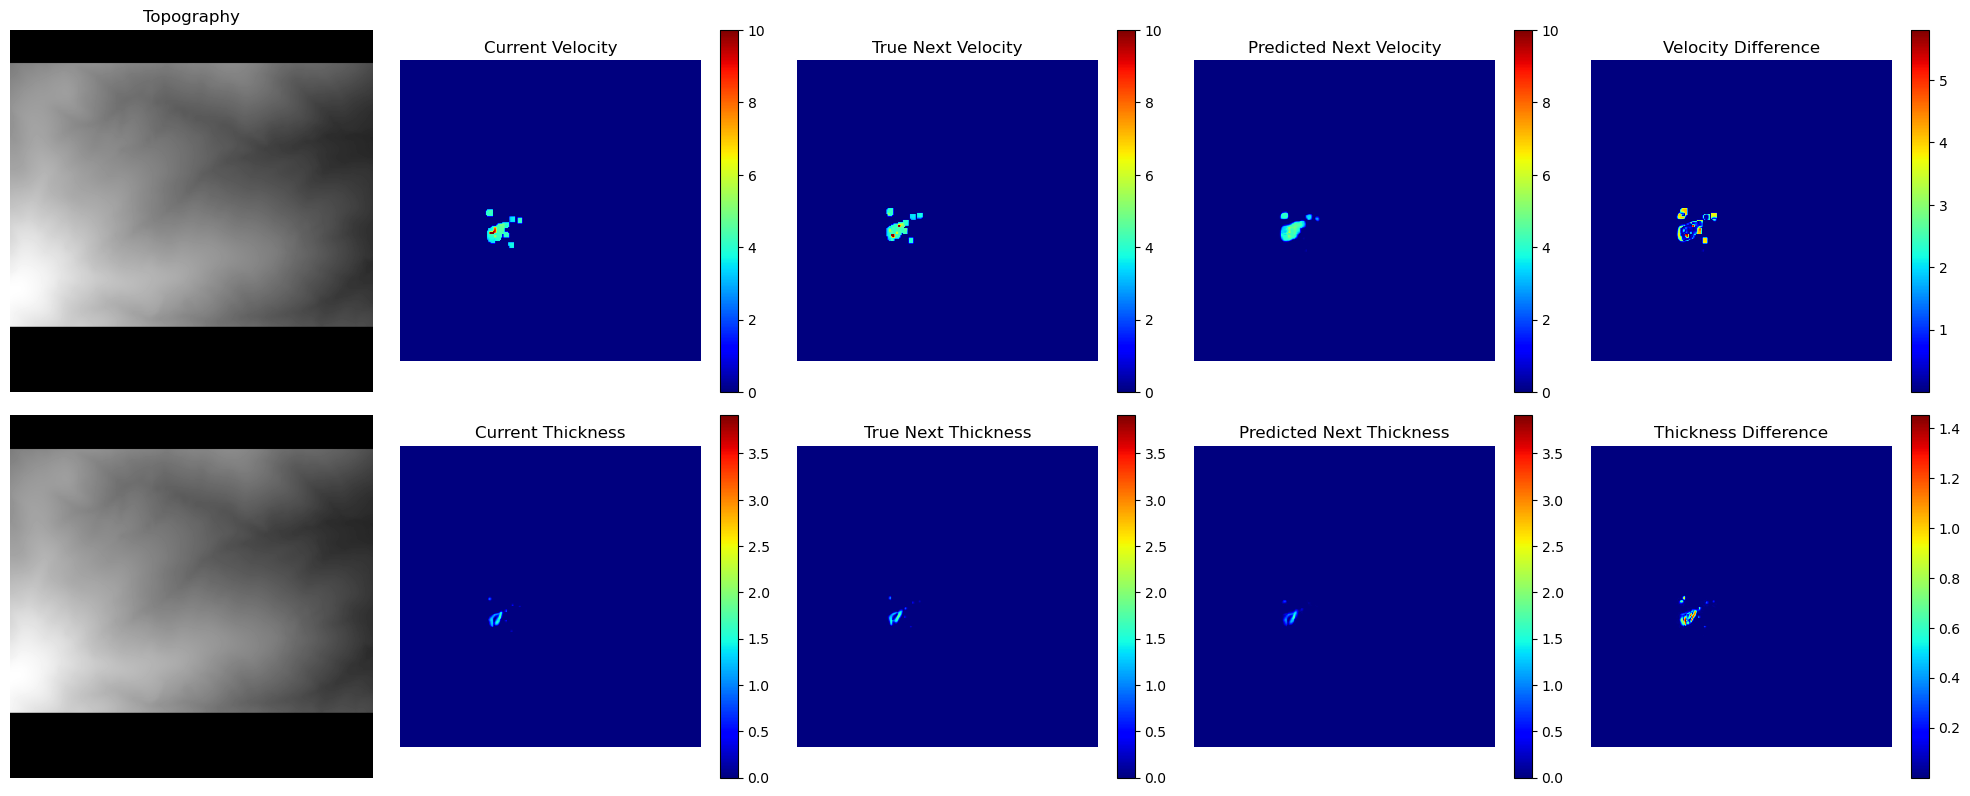

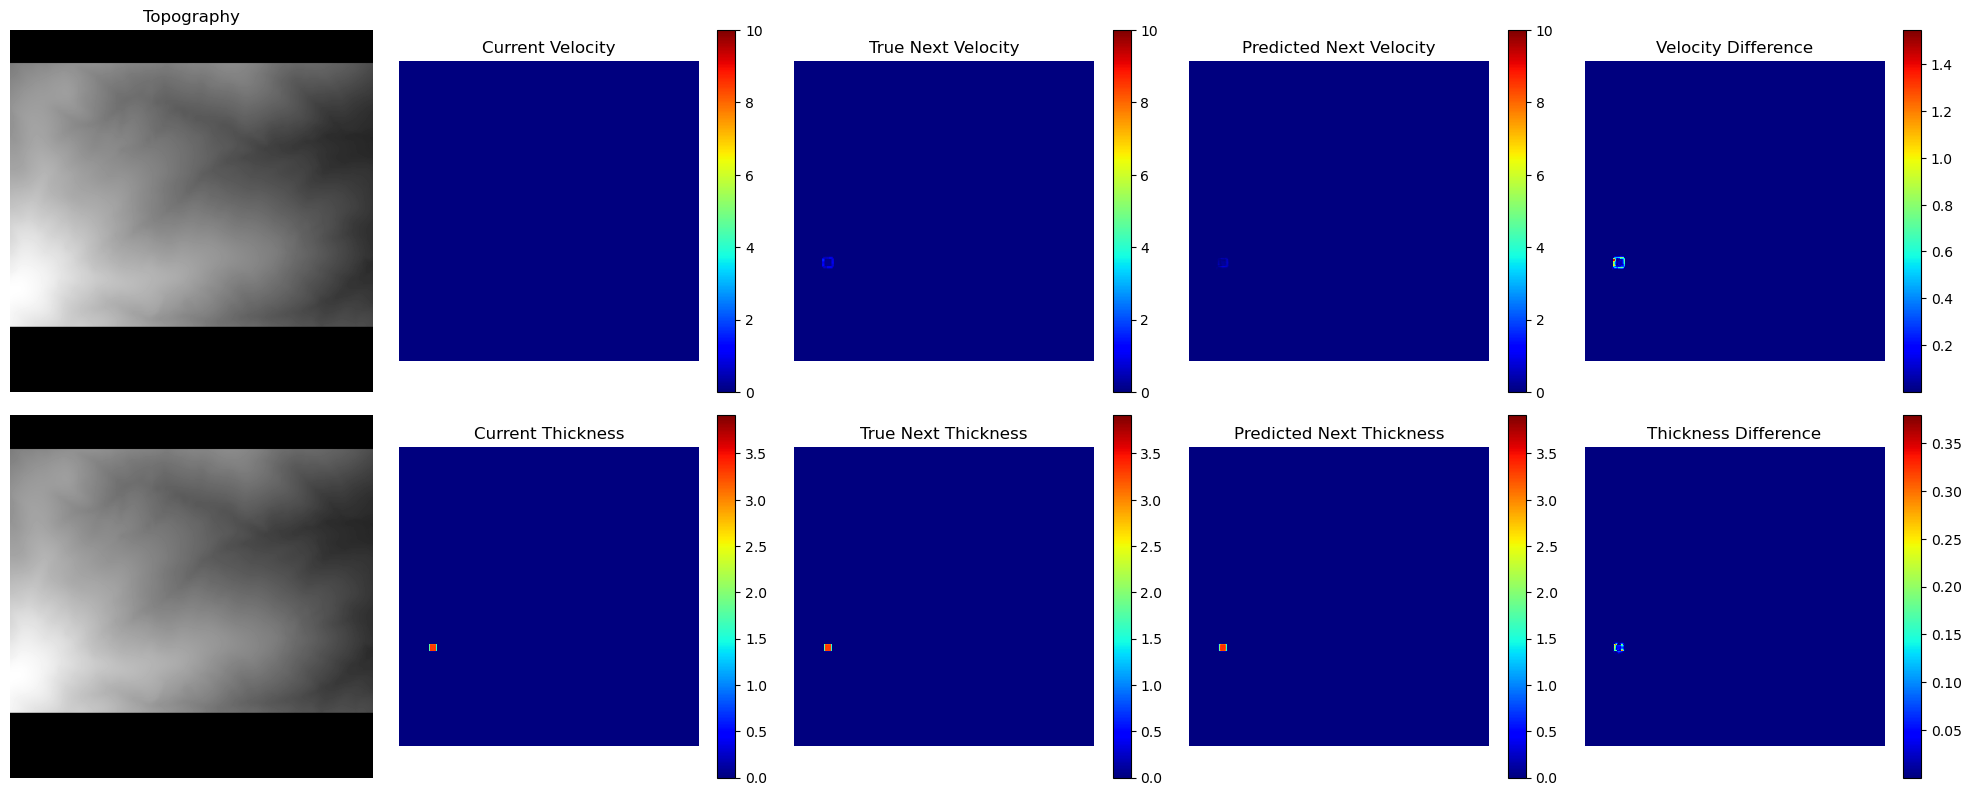

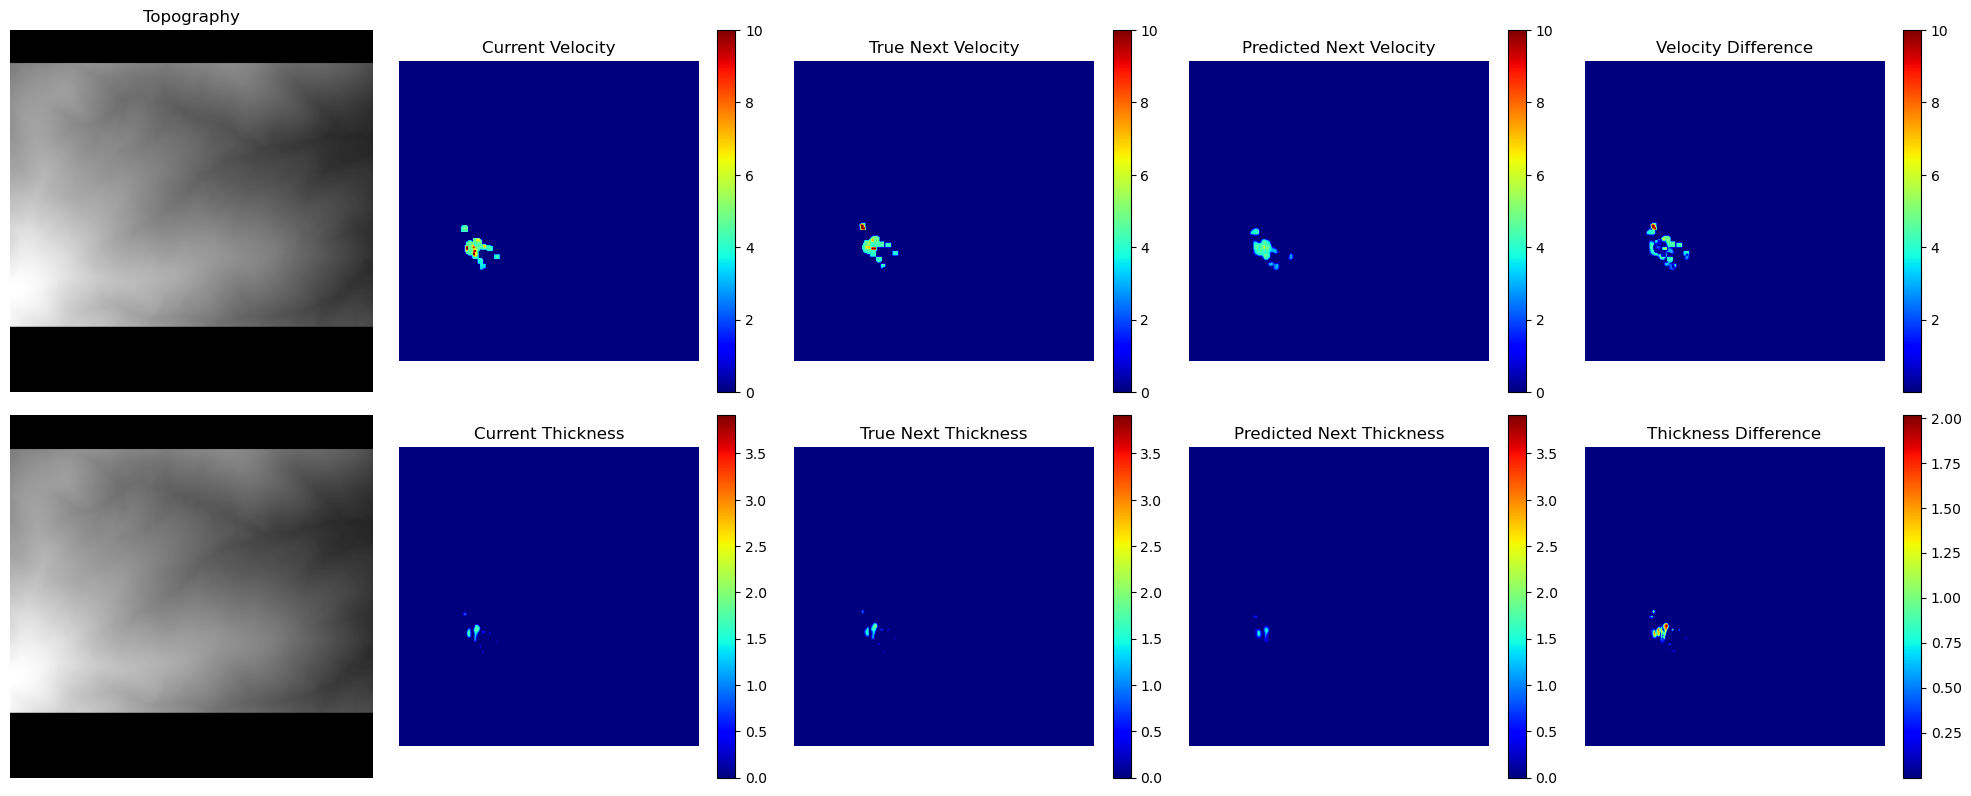

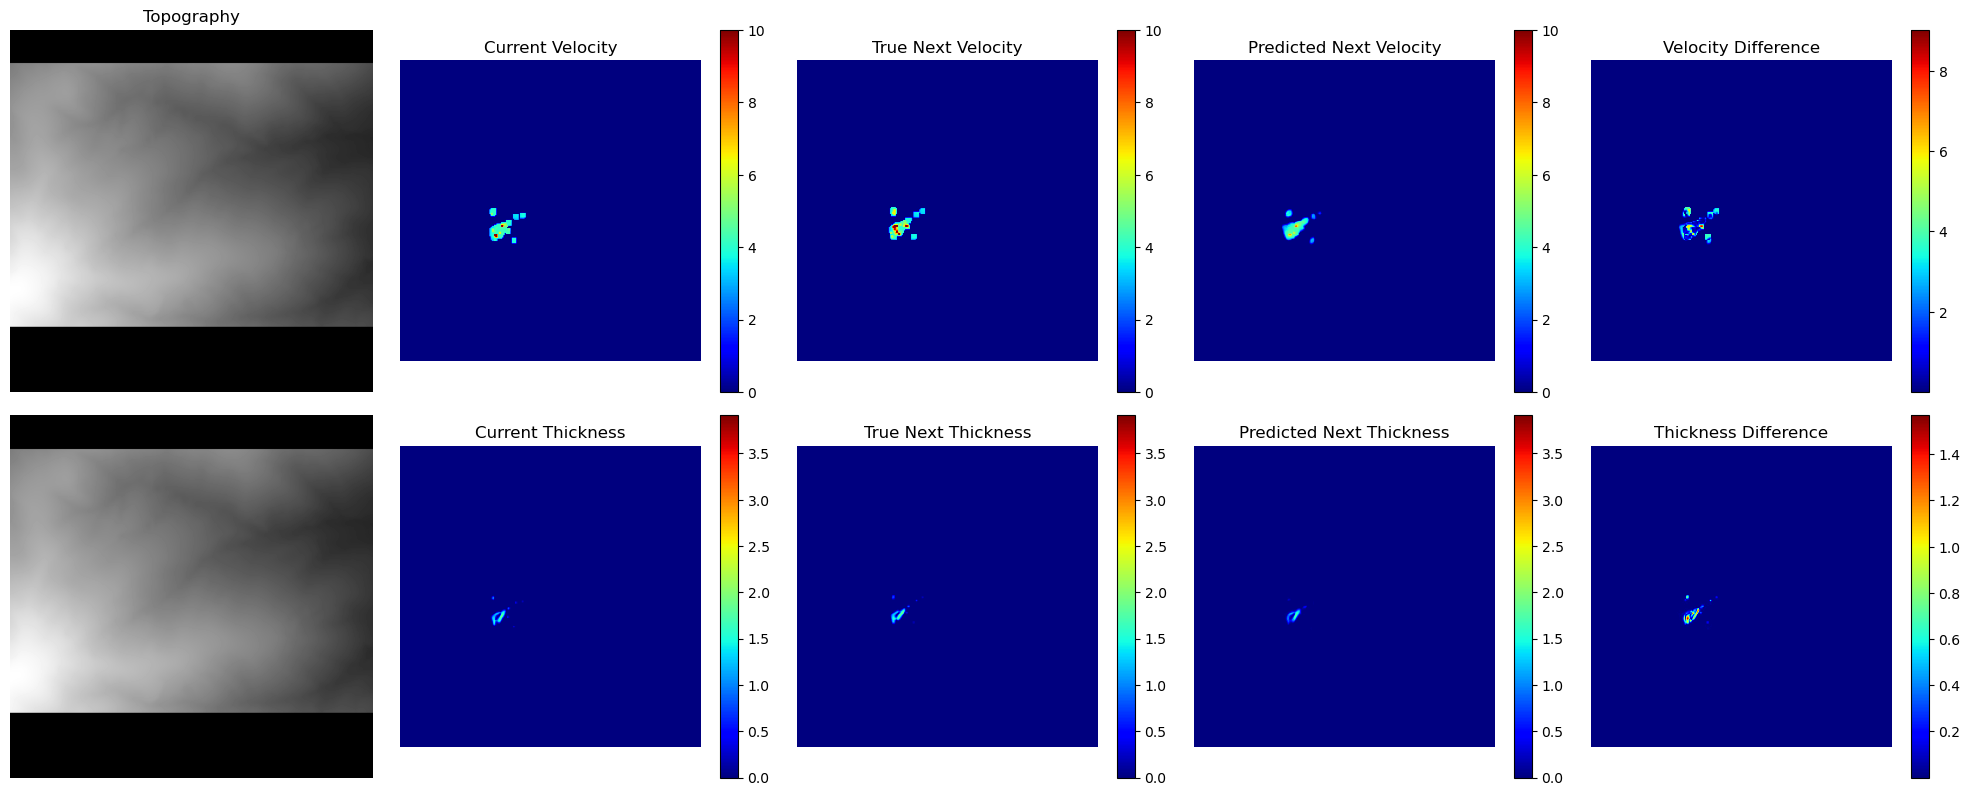

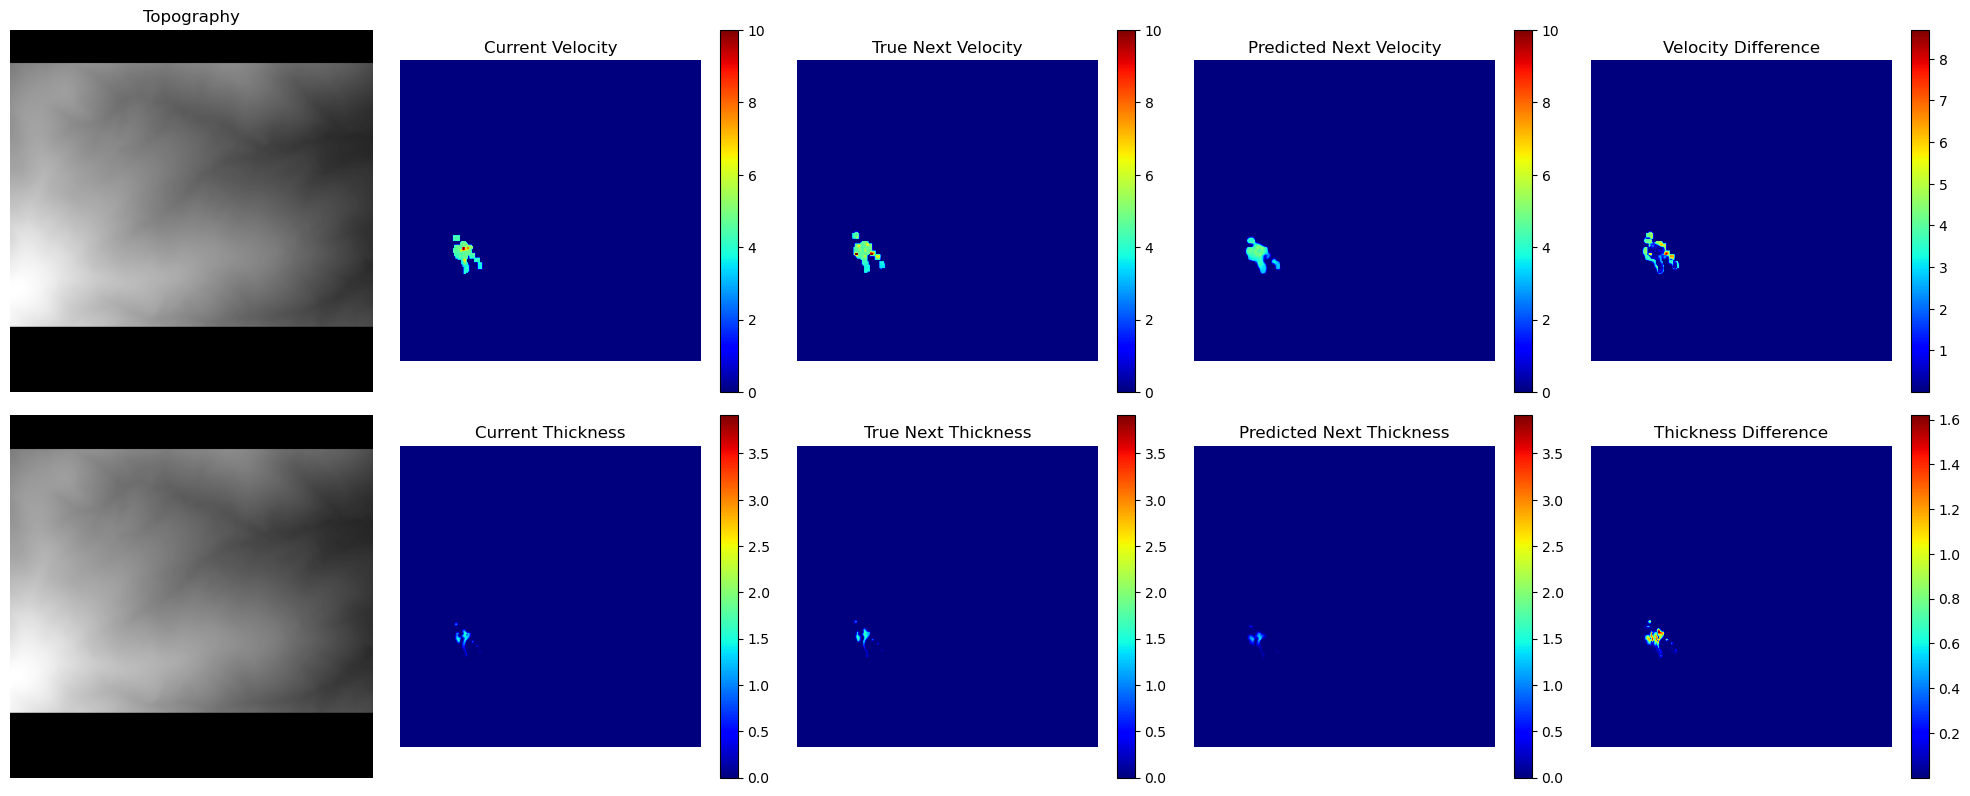

In [14]:
med_unet_trainer.plot_predictions(test_loader, num_predictions=5)

In [15]:
# Set up CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

large_unet = UNet(in_channels=3, out_channels=2, features=[64, 128, 256, 512, 1024]).to(device)

# Check if multiple GPUs are available and wrap the model using nn.DataParallel
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    # This will wrap the model for use with multiple GPUs
    large_unet = nn.DataParallel(large_unet)

# Define the loss function and optimizer
# criterion = nn.MSELoss()
criterion = nn.L1Loss()
# criterion = CustomDebrisLoss(loss_fn_zero=nn.SmoothL1Loss(), loss_fn_debris=nn.SmoothL1Loss(), debris_weight=0.66)
optimizer = Adam(cnn.parameters(), lr=1e-3)

large_unet_trainer = TrainerPairs(large_unet, optimizer, criterion, device, model_name="large_unet", checkpoint_dir=checkpoint_dir)

large_unet_trainer.load_checkpoint("/home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-20_base_model_comparison_l1Loss_batch32_LargeUNet/model_epoch_30.pth")

Using 2 GPUs!
Model loaded from /home/tom/repos/dyna-landslide-surrogate/checkpoints/2024-04-20_base_model_comparison_l1Loss_batch32_LargeUNet/model_epoch_30.pth


In [16]:
large_unet_trainer.test(test_loader)

Test Custom Loss: 0.4617
Test L1 Loss: 0.0026
Test MSE: 0.0074
Test RMSE: 0.0859
Test PSNR: 53.5879


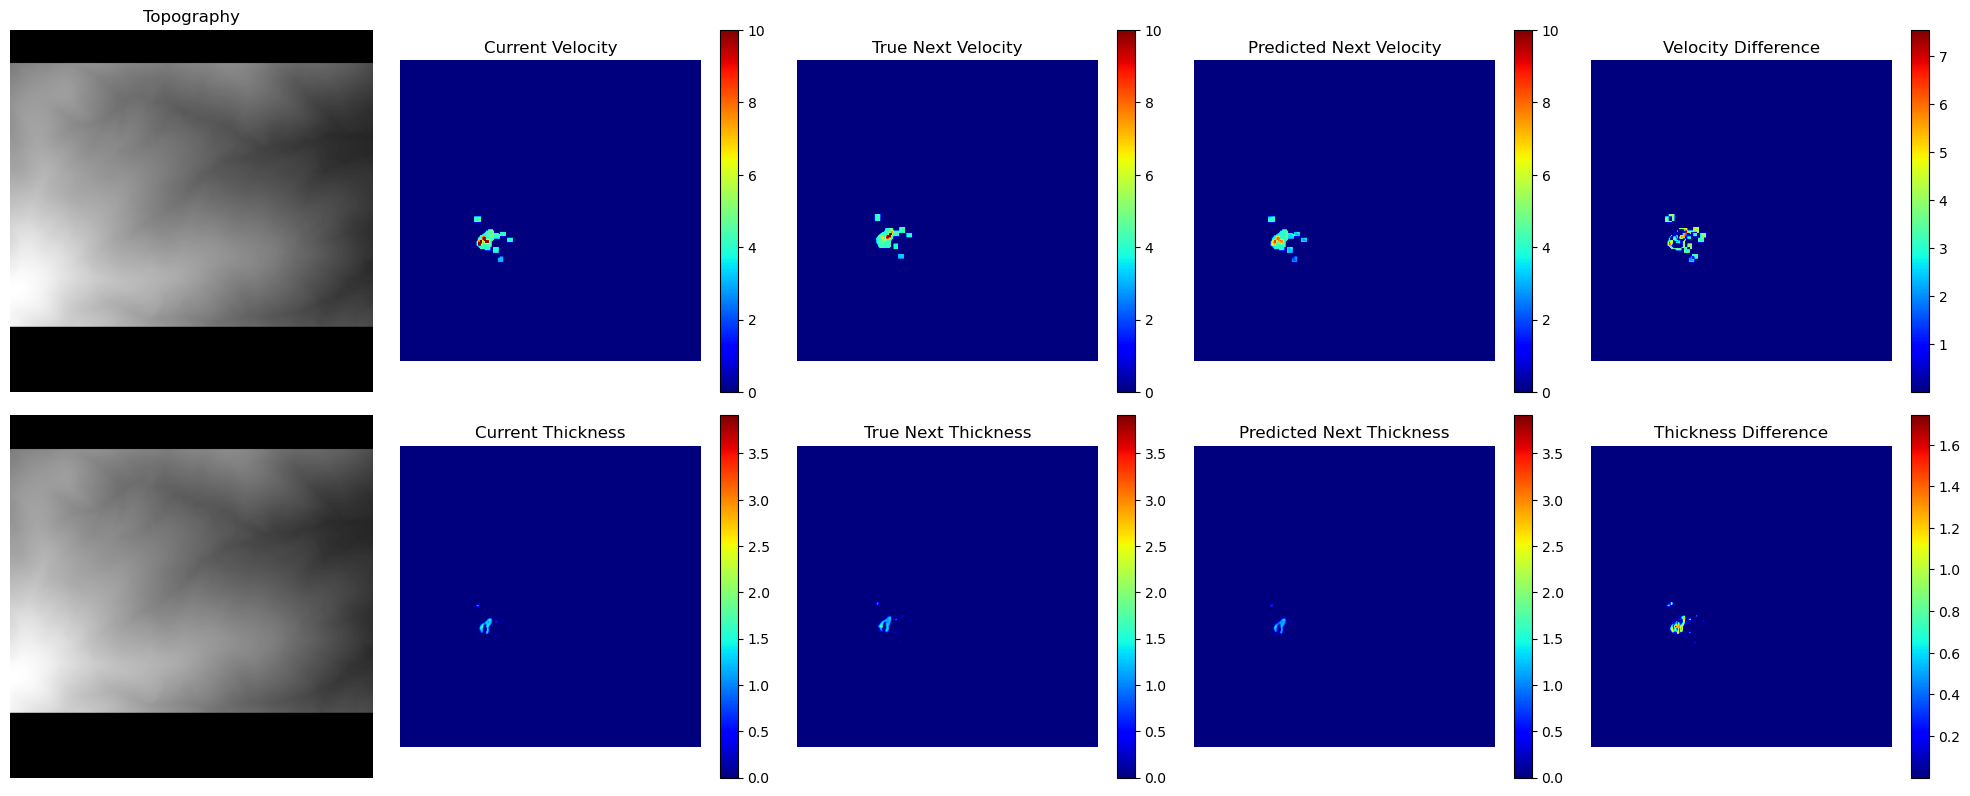

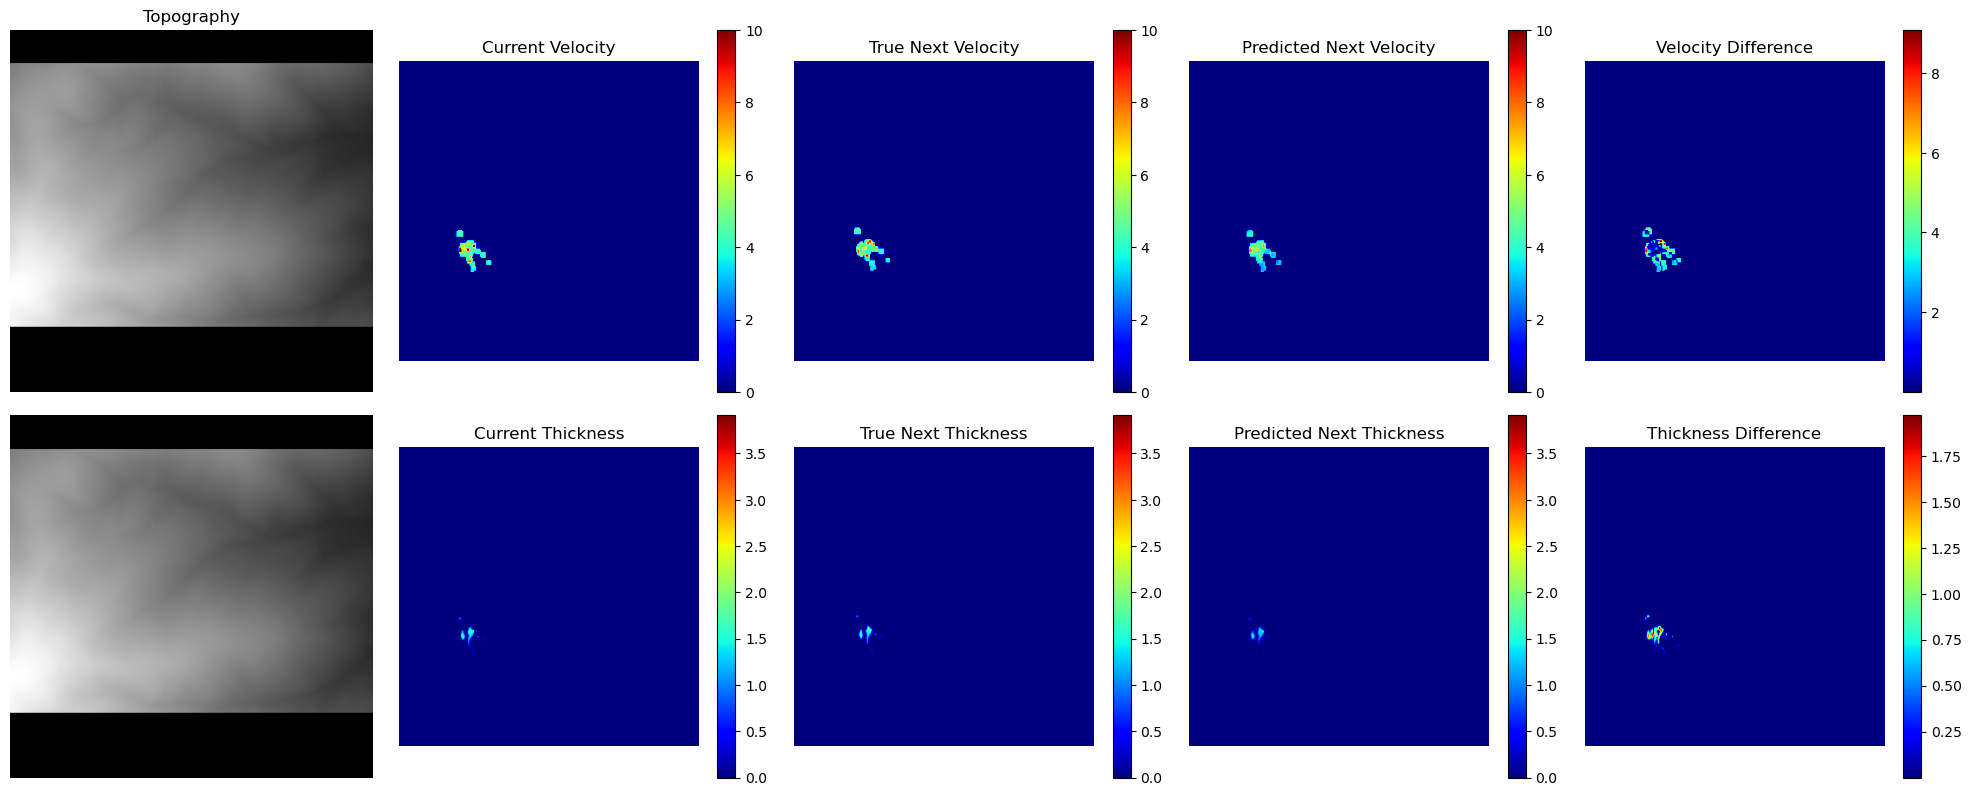

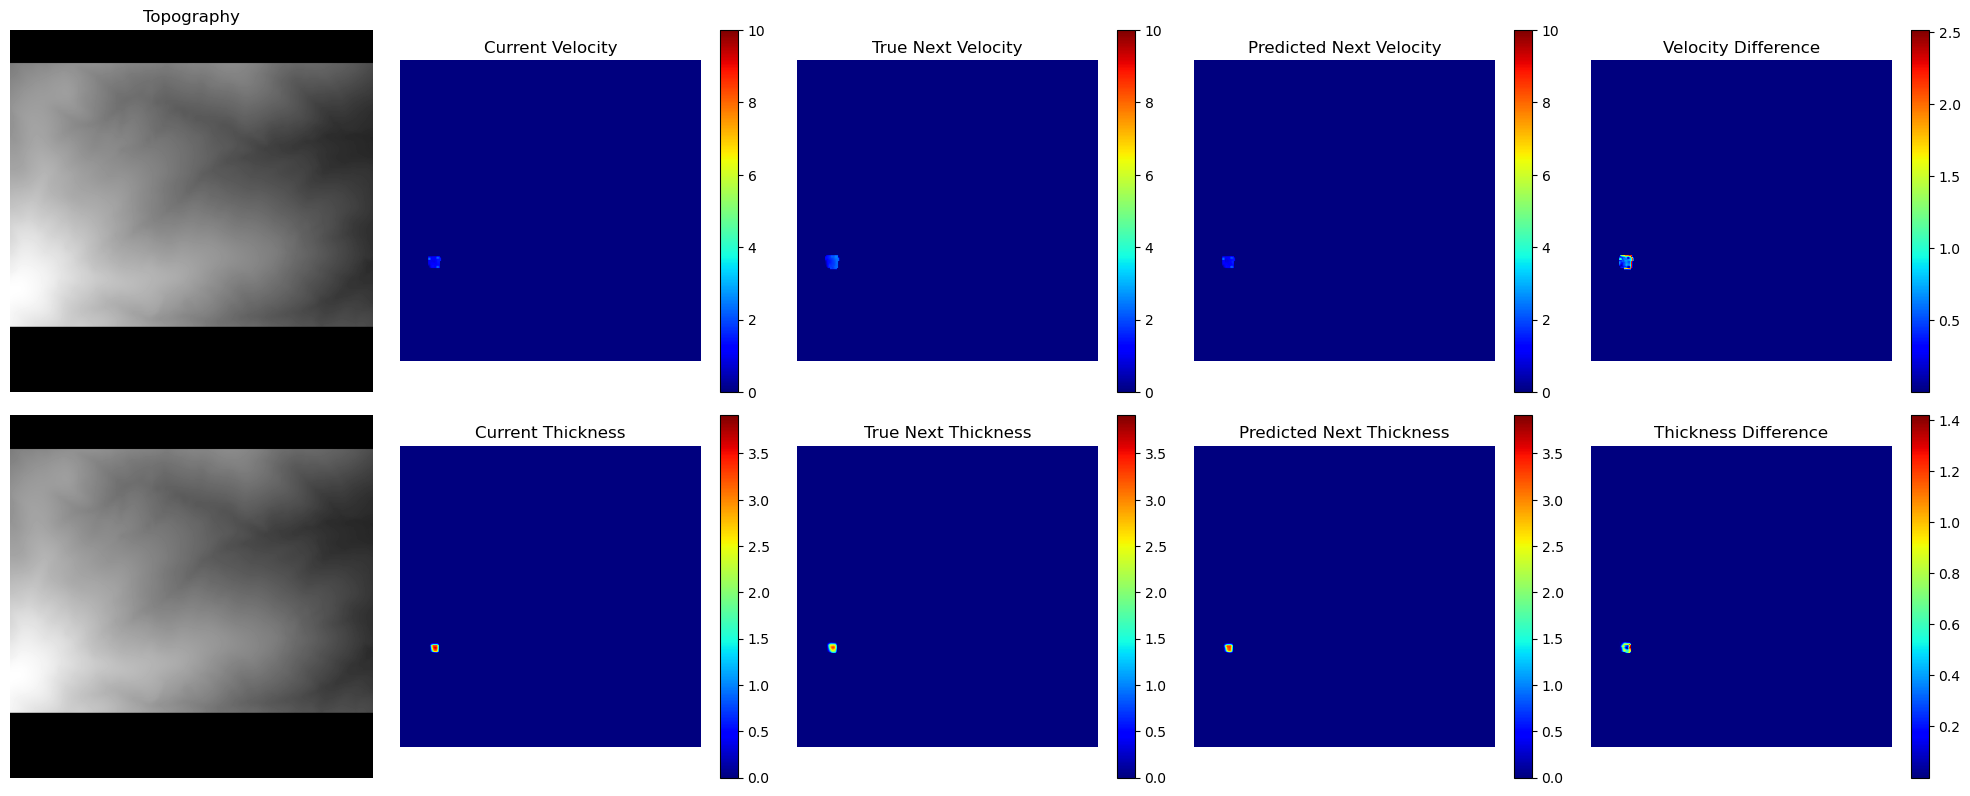

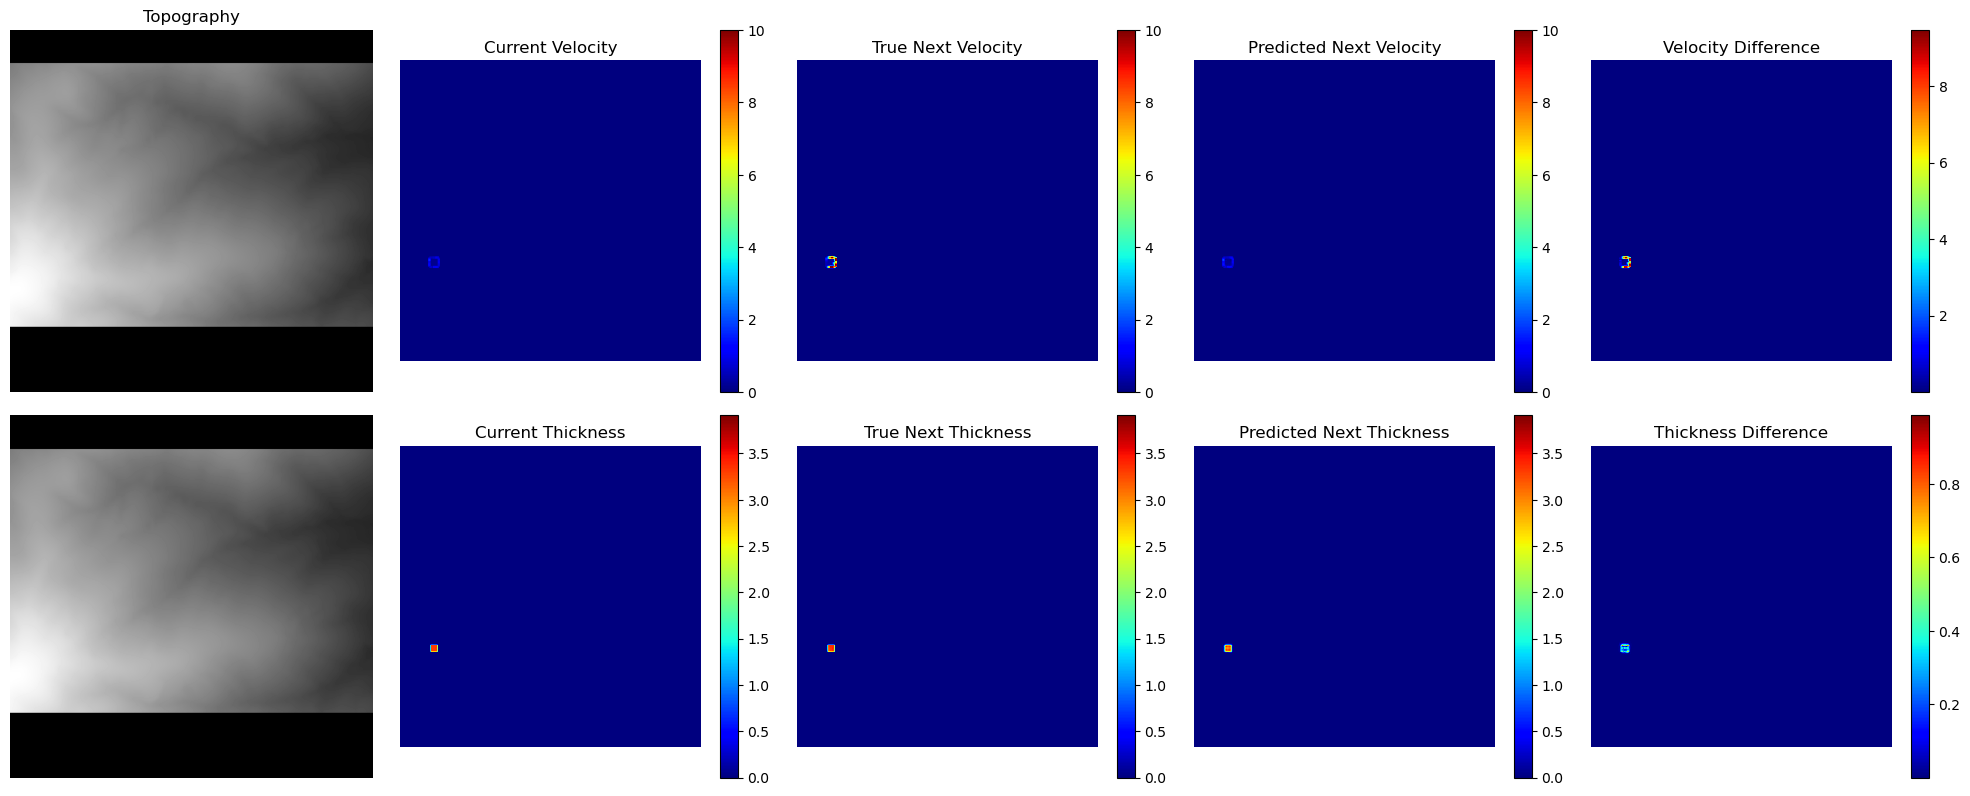

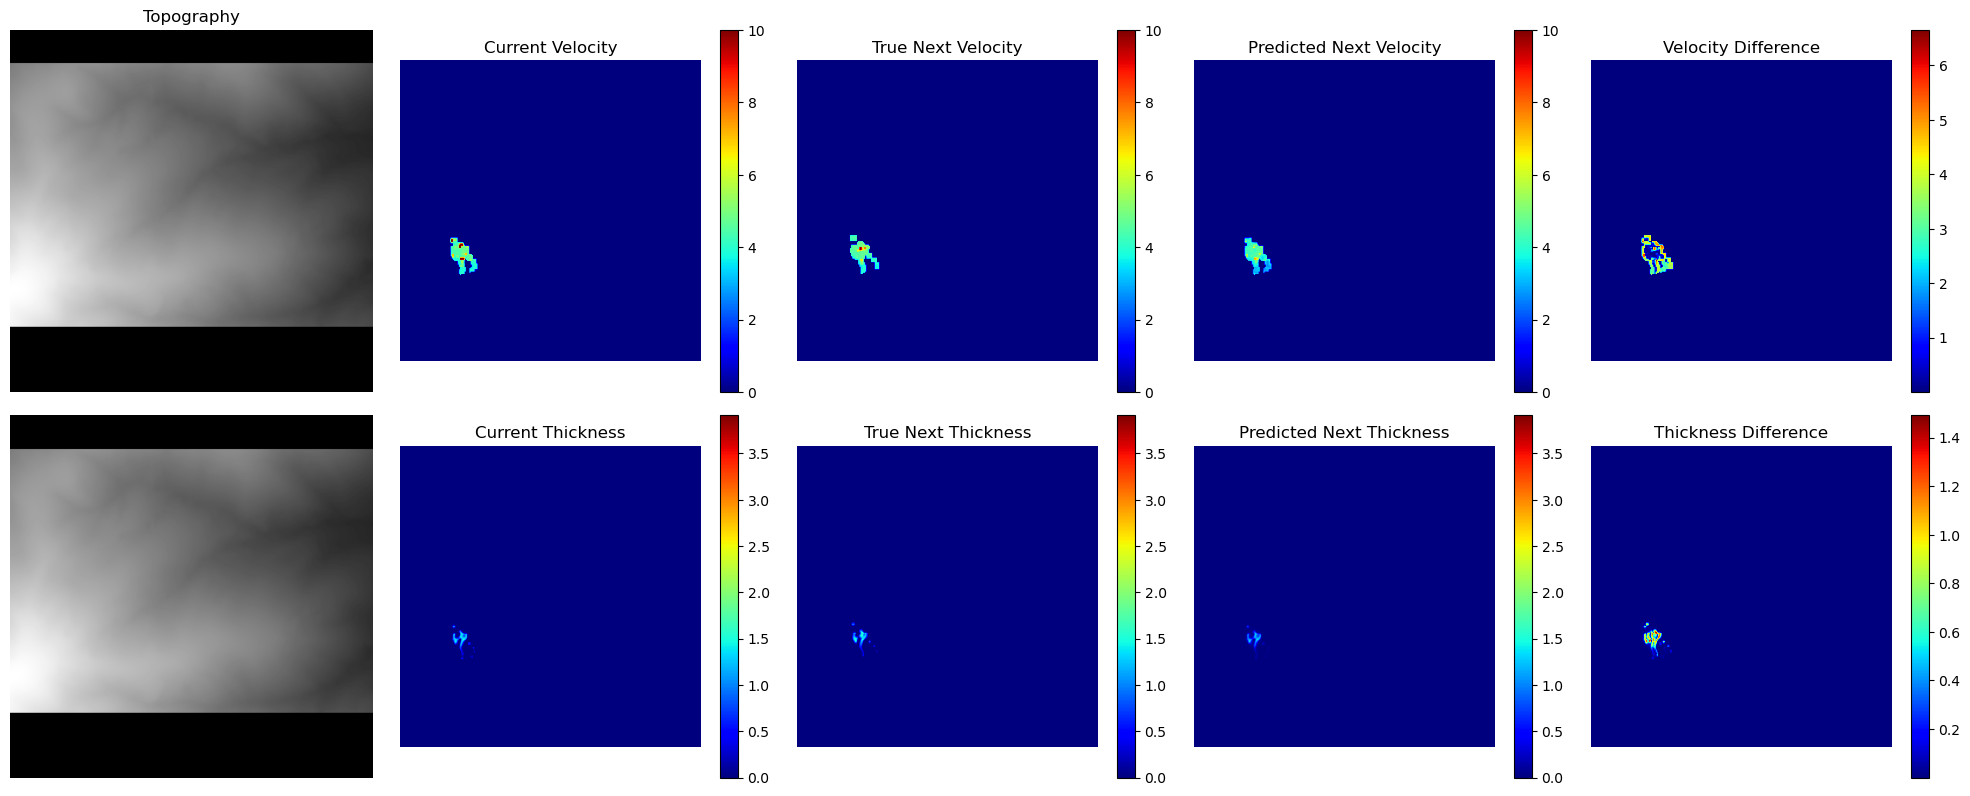

In [17]:
large_unet_trainer.plot_predictions(test_loader, num_predictions=5)